# Tutorial 1 - Particle sizing

Welcome to the first tutorial of this series! In this notebook, we'll explore one of the simplest yet insightful applications of Differential Dynamic Microscopy (DDM): particle sizing. Throughout this exploration, we'll be assisted by **fastDDM**.

Whether you're a seasoned researcher in the field of soft matter physics or a curious enthusiast, this notebook aims to provide a hands-on experience in leveraging DDM to uncover the hidden dynamics within colloidal systems.

### Purpose

The goal of this tutorial is to guide you through the fundamental principles of particle sizing using DDM. Specifically, we will:

0. Set up the workspace and import the libraries
    1. Set up the workspace.
    2. Give an overview of the samples under investigation.
    3. Import libraries.
1. Compute the structure function of image sequences using DDM.
    1. Load the image sequences.
    2. Calculate the corresponding structure function.
    3. Calculate the azimuthal average.
2. Fit the azimuthal average to gain insights into the sample's dynamics.
    1. Estimate the parameters.
    2. Fit the data using a diffusive dynamics model.
    3. Discuss the limits of the technique.
    4. Fit the parameters obtained from the fit to the data to retrieve the diffusion coefficient of the particles.
3. Convert the dynamical properties into particle size.

This tutorial assumes that you have a basic understanding of the features offered by fastDDM. If you need a refresher, consider reviewing the previous ["zeroth" tutorial](../Tutorial_0-Introduction/tutorial0.ipynb).

At the end of the notebook, there will an optional (starred) section:
* (*): Figures for the particle sizing section of the paper.

## 0. Initial setup
### 0.A. Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using [open-source microscopy videos](https://datashare.ed.ac.uk/handle/10283/4858) provided with the paper [Bradley et al, *Soft Matter*, 2023, **19**, 8179](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c). If you haven't done so already, download the files and unzip the main folder (and the `Video_dataset.zip` within it) in the directory containing these tutorials.

Your main directory tree should resemble the following:
```
.
├── DS_10283_4858
│   └── Video_dataset
│       └── third_vid_dataset
├── Tutorial_1-Particle_sizing
└── ...
```

### 0.B. Samples description

The samples under study consist of dilute solutions of polystyrene (PS) spheres with various sizes dispersed in Milli-Q water.
The batches, obtained from Thermo Scientific (5000 series), have diameters ranging from 60 nm to 2.1 µm.
These samples are prepared at a volume fraction $\phi=10^{-5}$ and loaded into 0.4 $\times$ 4 $\times$ 50 mm glass capillaries (Vitrocom).
For more details, refer to the [full article](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c).

### 0.C. Let's get started

Now that the stage is set, let's begin by importing some essential libraries, including `fastddm`.

In [1]:
%matplotlib notebook

import gc
import os
import lmfit
import numpy as np

# set numpy print options to limit the length of the output
np.set_printoptions(threshold=0)

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

# get rid of the 'too many open images' warning
mpl.rcParams.update({'figure.max_open_warning': 0})

# color space helper
def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fd
from fastddm.fit import fit

Here, we define the paths to the videos and the labels indicating the nominal particle size.

In [2]:
# directory containing the videos (split long line)
main_directory = (
    '../DS_10283_4858/Video_dataset/third_vid_dataset/'
    '27_07_2021_BF_Scaling_Neat/'
)

# file names (including enclosing folder)
file_names = [
    'BF20x_1x1_200fps_Pos3_3/BF20x_1x1_200fps_Pos3_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos1_3/BF20x_1x1_200fps_Pos1_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos4_3/BF20x_1x1_200fps_Pos4_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos0_3/BF20x_1x1_200fps_Pos0_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos5_3/BF20x_1x1_200fps_Pos5_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos2_3/BF20x_1x1_200fps_Pos2_3_MMStack_Default.ome.tif',
]

# create full paths
file_paths = [os.path.join(main_directory, fn) for fn in file_names]

# list of labels
labels = [
    '60 nm',
    '120 nm',
    '240 nm',
    '500 nm',
    '1.1 µm',
    '2.1 µm',
]

# list nominal diameters
D_nom = [60, 120, 240, 500, 1100, 2100]

## 1. Structure function calculation
### 1.A. Load and visualize images

The experimental parameters are listed in Sec. 4 of the reference [paper](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c).
Videos are acquired at 200 fps with a Hamamatsu Orca Flash 4.0 camera (pixel size $6.5 \, \mathrm{µm}$) using a 20$\times$, NA 0.5 objective. This gives an effective pixel size of $\delta_{px} = 6.5/20 \, \mathrm{µm} = 325 \, \mathrm{nm}$.

In [3]:
# experimental parameters
frame_rate = 200       # frames per second
pixel_size = 6.5/20    # microns per pixel

It's always useful to begin by inspecting the videos. We'll load the first frame from each movie and display the images in a grid.

<IPython.core.display.Javascript object>


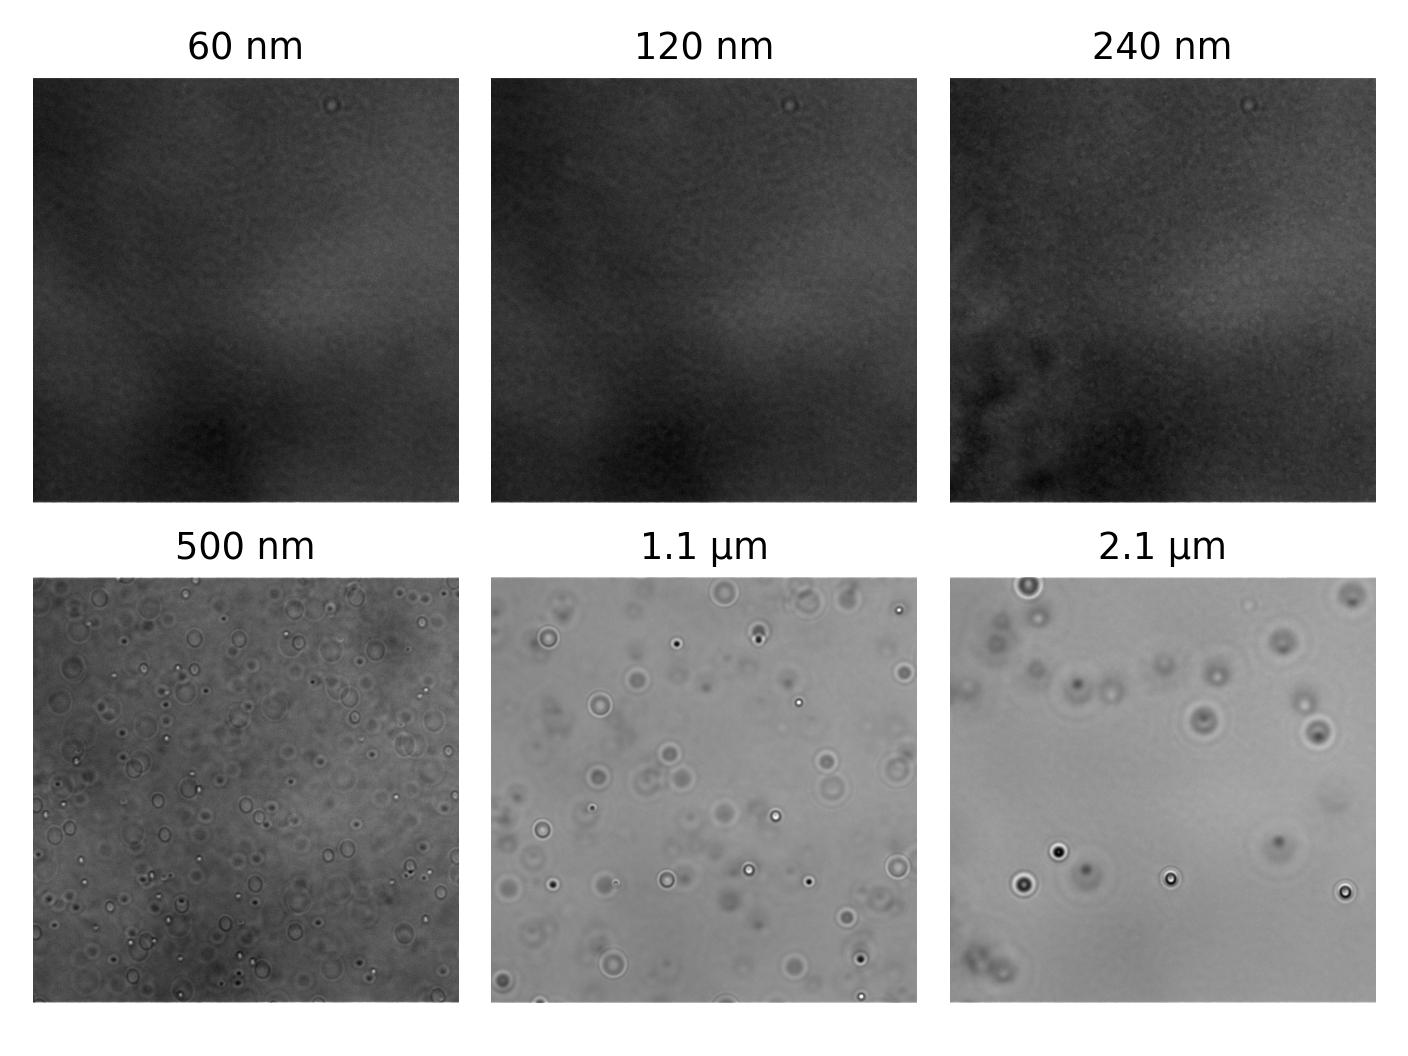

In [4]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=3, nrows=2)
axs = gs.subplots()

# read the images
images = []
for path in file_paths:
    images.append(fd.read_images(path, seq=[0]))

for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img, cmap='gray')
    
    ax.set_axis_off()
    ax.set_title(label)

fig.tight_layout();

Observe that the particles are visible only in the lower panels (500 nm to 2.1 $\mu$m), whereas they remain indiscernible in the upper panels due to their size being too small to be optically resolved.

### 1.B-C. Structure function and azimuthal average calculation

The structure function stands as a foundation tool for unveiling spatial correlations and dynamic features within images. For samples having an isotropic dynamics, the statistics can be enhanced by calculating the azimuthal average of the structure function.

In order to save space in the memory, after the calculation of the azimuthal average we will delete the structure functions and the image sequences. We will not use them afterwards.

The process for the calculation for each image sequence is as follows:

1. **Data preparaton:** We initiate the process by loading the image sequence from the file.
2. **Structure function calculation:** We apply DDM to the image sequence to derive the structure function.
3. **Azimuthal average calculation:** We will calculate the azimuthal average of the structure function and store it in a list for later use.
4. **Delete unused variables:** Finally, we will delete the image sequence and the structure function, keeping only the azimuthal average.

Use the following cell to select the `core` and `mode` you want to use for the calculation of the structure function. Keep in mind that:

* `fft` is (way) faster than `diff`
* `cuda` is faster than `cpp` which is faster than `py`
* `py` is always available

In [5]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
CORE = 'py'
#CORE = 'cpp'
#CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

In [6]:
print('--- Calculating structure functions and azimuthal averages... ---')

aa = []

for num, f in enumerate(file_paths):
    # notify user on progress
    print(f'Analyzing movie #{num+1} of {len(file_paths)} ...')
    
    # read image sequence
    img_seq = fd.read_images(f)
    
    # compute structure function
    lags = range(1, int(len(img_seq) / 2))              # we analyze delays only up to half the length of the video
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size
    dqt.set_frame_rate(frame_rate)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                       # number of bins
    bin_range = (0, dqt.ky[-1])                       # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
    aa.append(fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm))
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()

--- Calculating structure functions and azimuthal averages... ---
Analyzing movie #1 of 6 ...
Analyzing movie #2 of 6 ...
Analyzing movie #3 of 6 ...
Analyzing movie #4 of 6 ...
Analyzing movie #5 of 6 ...
Analyzing movie #6 of 6 ...


Only for the purpose of visualization, we also create a resampled azimuthal average using logarithmically-spaced time delays.

In [7]:
# resample azimuthal average
aa_resampled = []

for a in aa:
    # get 100 logspaced integers and rescale then with proper time
    new_taus = fd.lags.logspace_int(len(a.tau), num=100, endpoint=True) * a.tau[0]
    # resample
    aa_resampled.append(a.resample(new_taus))

## 2. Fit the data
### 2.A. Estimate noise and amplitude

To give good starting points to the fit routine, we estimate the amplitude and noise term of the structure function.

In [8]:
# estimate noise and amplitude terms
Bq = []
Aq = []

for a in aa:
    # estimate noise term using the 'polynomial' method
    B_est, _ = fd.noise_est.estimate_camera_noise(a, mode='polyfit', num_points=5)
    Bq.append(B_est)
    
    # estimate total amplitude
    Aq_plus_Bq = 2 * a.var
    
    # estimate static amplitude 
    Aq.append(Aq_plus_Bq - B_est)

### 2.B. Fit with simple exponential

For particles undergoing Brownian motion, the intermediate scattering function is well-described by a simple exponential function:

$$
f(q, \Delta t) = \exp [- \Gamma(q) \Delta t] ,
$$
where $\Gamma(q) = D q^2$ is the relaxation rate and $D$ is the particles' diffusion coefficient.

We can use the `fastddm.fit_models.simple_exponential_model`, which implements the exponential function in the structure function model:

$$
d(q, \Delta t) = A(q) [1 - \exp(-\Gamma(q) \Delta t)] + B(q) .
$$

In [9]:
from fastddm.fit import fit_multik
from fastddm.fit_models import simple_exponential_model as model

# choose reference k vector
k_ref = 20

To initiate a fitting process with a reliable starting value for the relaxation rate, we can estimate $\tau = 1/\Gamma$ by first estimating the intermediate scattering function and determining the delay where it has a value of $1/\mathrm{e}$.

In [10]:
# initialize lists
fit_res = []
model_res = []

for a, B, A in zip(aa, Bq, Aq):
    # estimate intermediate scattering function at `k_ref`
    fqt = 1 - (a.data[k_ref] - B[k_ref]) / A[k_ref]
    
    # estimate Gamma
    tau = a.tau[np.argmin(np.abs(fqt - np.exp(-1)))]
    Gamma0 = 1 / tau
    
    # set model parameters hints
    model.set_param_hint('A', value=A[k_ref])
    model.set_param_hint('B', value=B[k_ref])
    model.set_param_hint('Gamma', value=Gamma0)
    
    # fit
    fr, mr = fit_multik(a, model, k_ref, use_err=True, return_model_results=True)
    fit_res.append(fr)
    model_res.append(mr)

Now, we can visualize the output from the fit. We first display the comparison of the intermediate scattering function $f(\Delta t; q)$ and the best fit, both obtained by inverting the structure function data and best fit with the resulting $A(q)$ and $B(q)$ from the fit

$$
f(q, \Delta t) = 1 - \frac{d(q, \Delta t) - B(q)}{A(q)}
$$

<IPython.core.display.Javascript object>


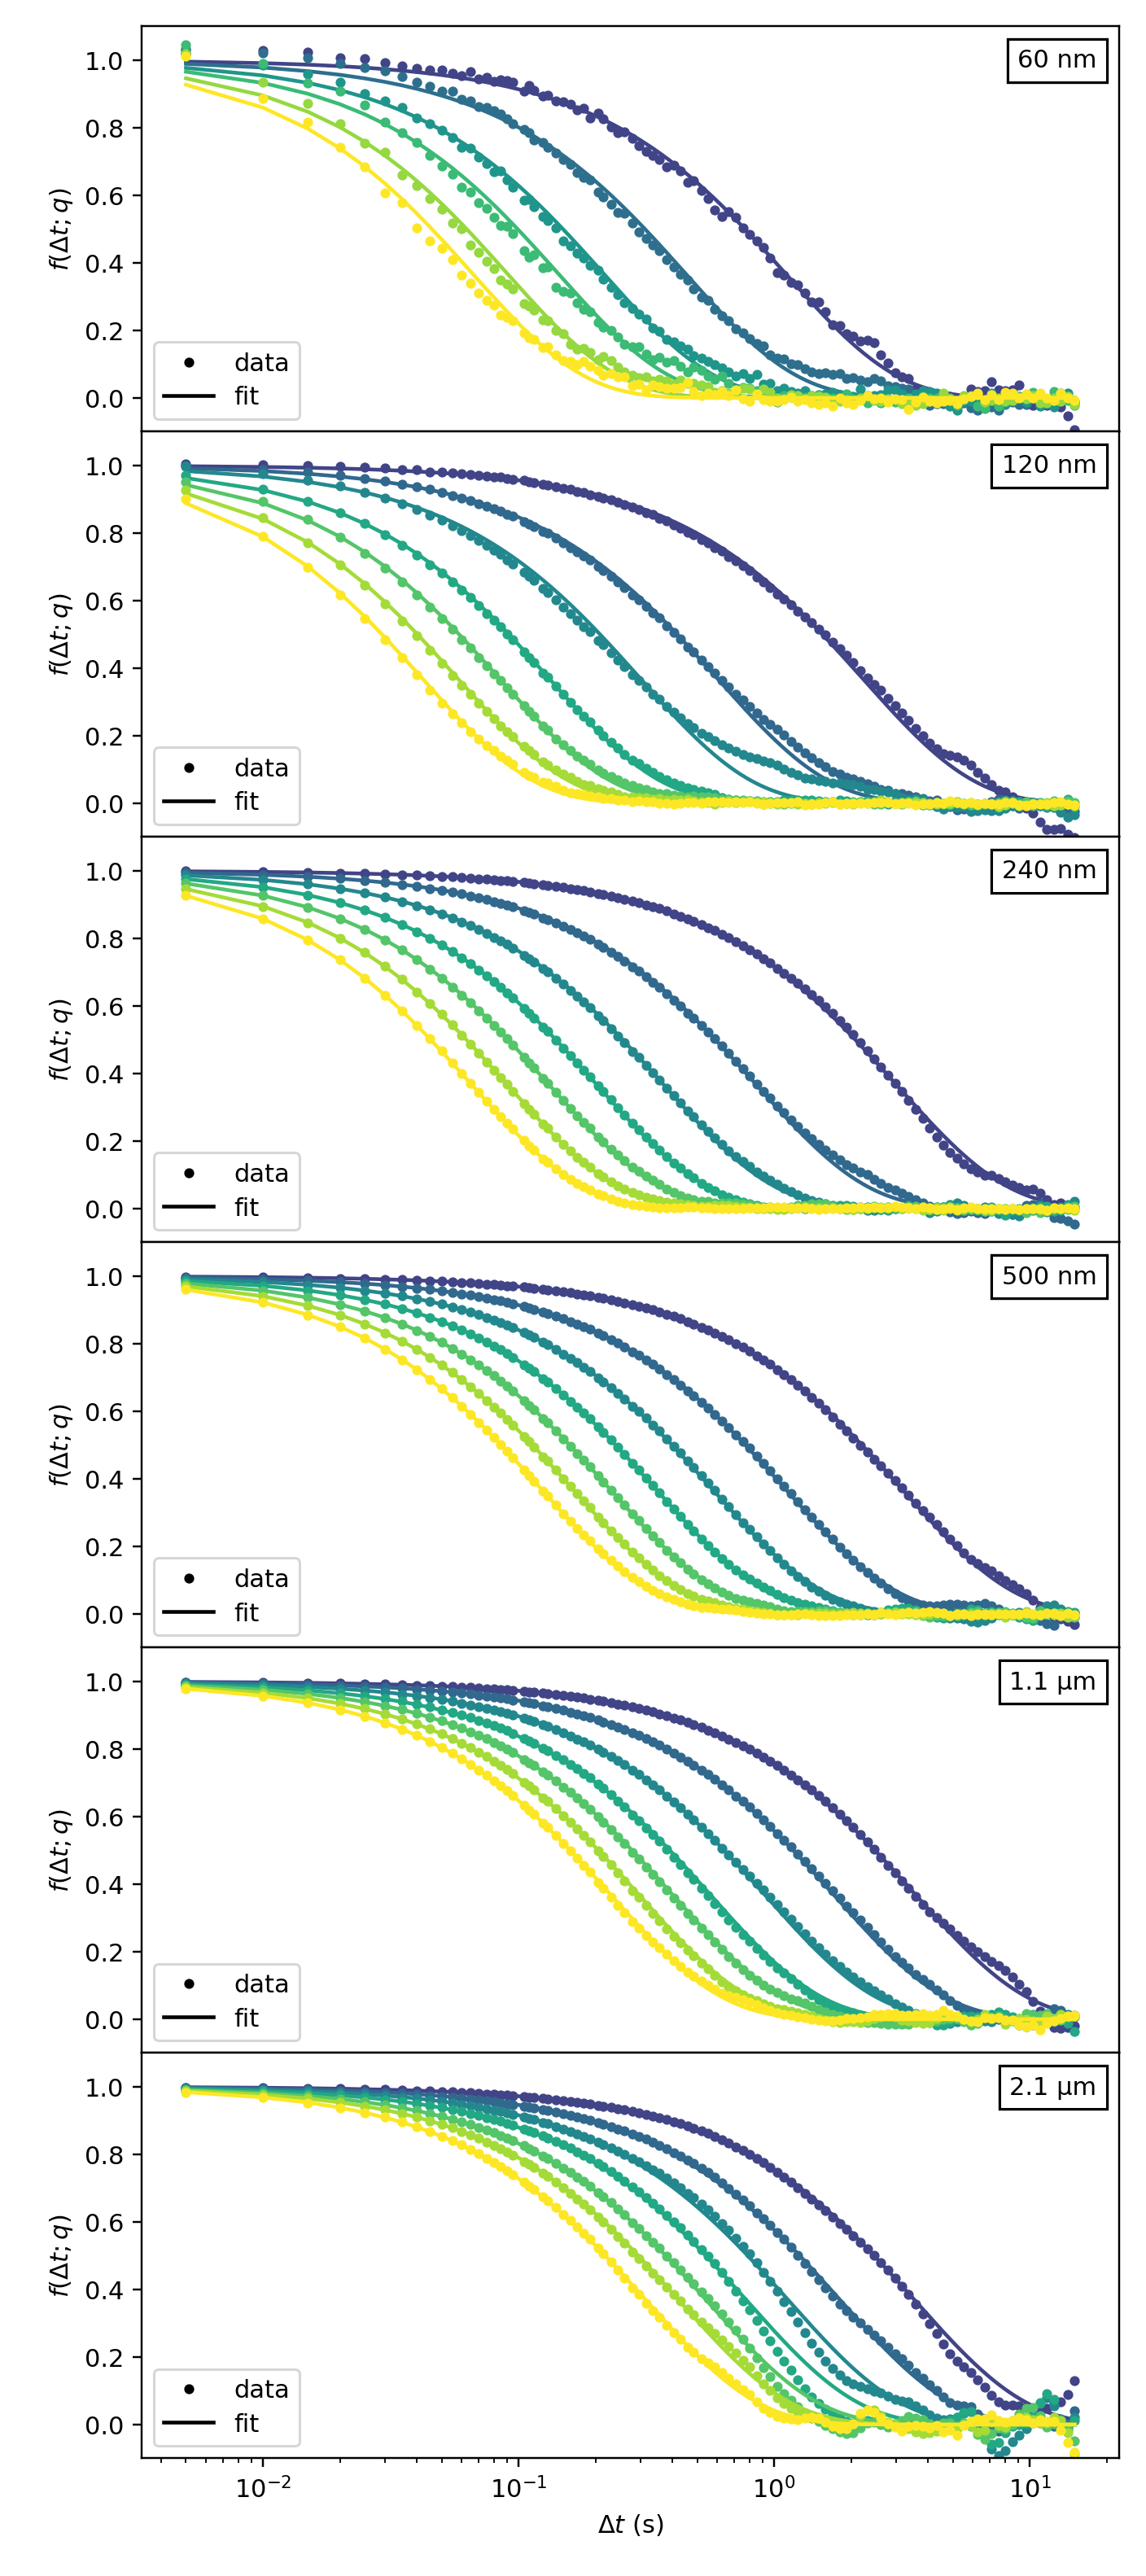

In [11]:
fig = plt.figure()
fig.set_figheight((len(aa) / 2) * fig.get_figheight())
gs = fig.add_gridspec(len(aa), hspace=0)
axs = gs.subplots(sharex=True)

# select range of wave vector indices
k_min = [10, 10, 10, 15, 20, 30]
k_max = [50, 80, 80, 80, 90, 100]
k_step = [7, 10, 10, 10, 10, 10]

k_range = [range(k_m, k_M, k_s) for k_m, k_M, k_s in zip(k_min, k_max, k_step)]

# plot curves
for ax, a, ar, fr, mr, kr, l in zip(axs, aa, aa_resampled, fit_res, model_res, k_range, labels):
    cspace = color_space(len(kr))
    
    for k_idx, c in zip(kr, cspace):
        # calculate intermediate scattering function
        fqt = 1 - (ar.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
        fqt_fit = 1 - (mr[k_idx].best_fit - fr['B'][k_idx]) / fr['A'][k_idx]
    
        # plot
        ax.plot(ar.tau, fqt, '.', color=c)
        ax.plot(a.tau, fqt_fit, '-', color=c)
        
        # misc
        ax.set_ylabel(r'$f(\Delta t; q)$')
        ax.set_ylim(-0.1, 1.1)
        # label
        at = AnchoredText(l, prop=dict(size=10), frameon=True, loc='upper right')
        ax.add_artist(at)
        # custom legend
        custom_lines = [
            Line2D([0], [0], marker='.', linestyle='none', color='black', label='data'),
            Line2D([0], [0], linestyle='-', color='black', label='fit'),
        ]
        ax.legend(handles=custom_lines, labelspacing=0.4, loc='lower left')
        
axs[-1].set_xscale('log')
axs[-1].set_xlabel(r'$\Delta t$ (s)')

fig.tight_layout();

The quality of the fit is rather good for all particle sizes within the inspected $q$ range. We also show the fit parameters, $\Gamma$, $A$, and $B$.

<IPython.core.display.Javascript object>


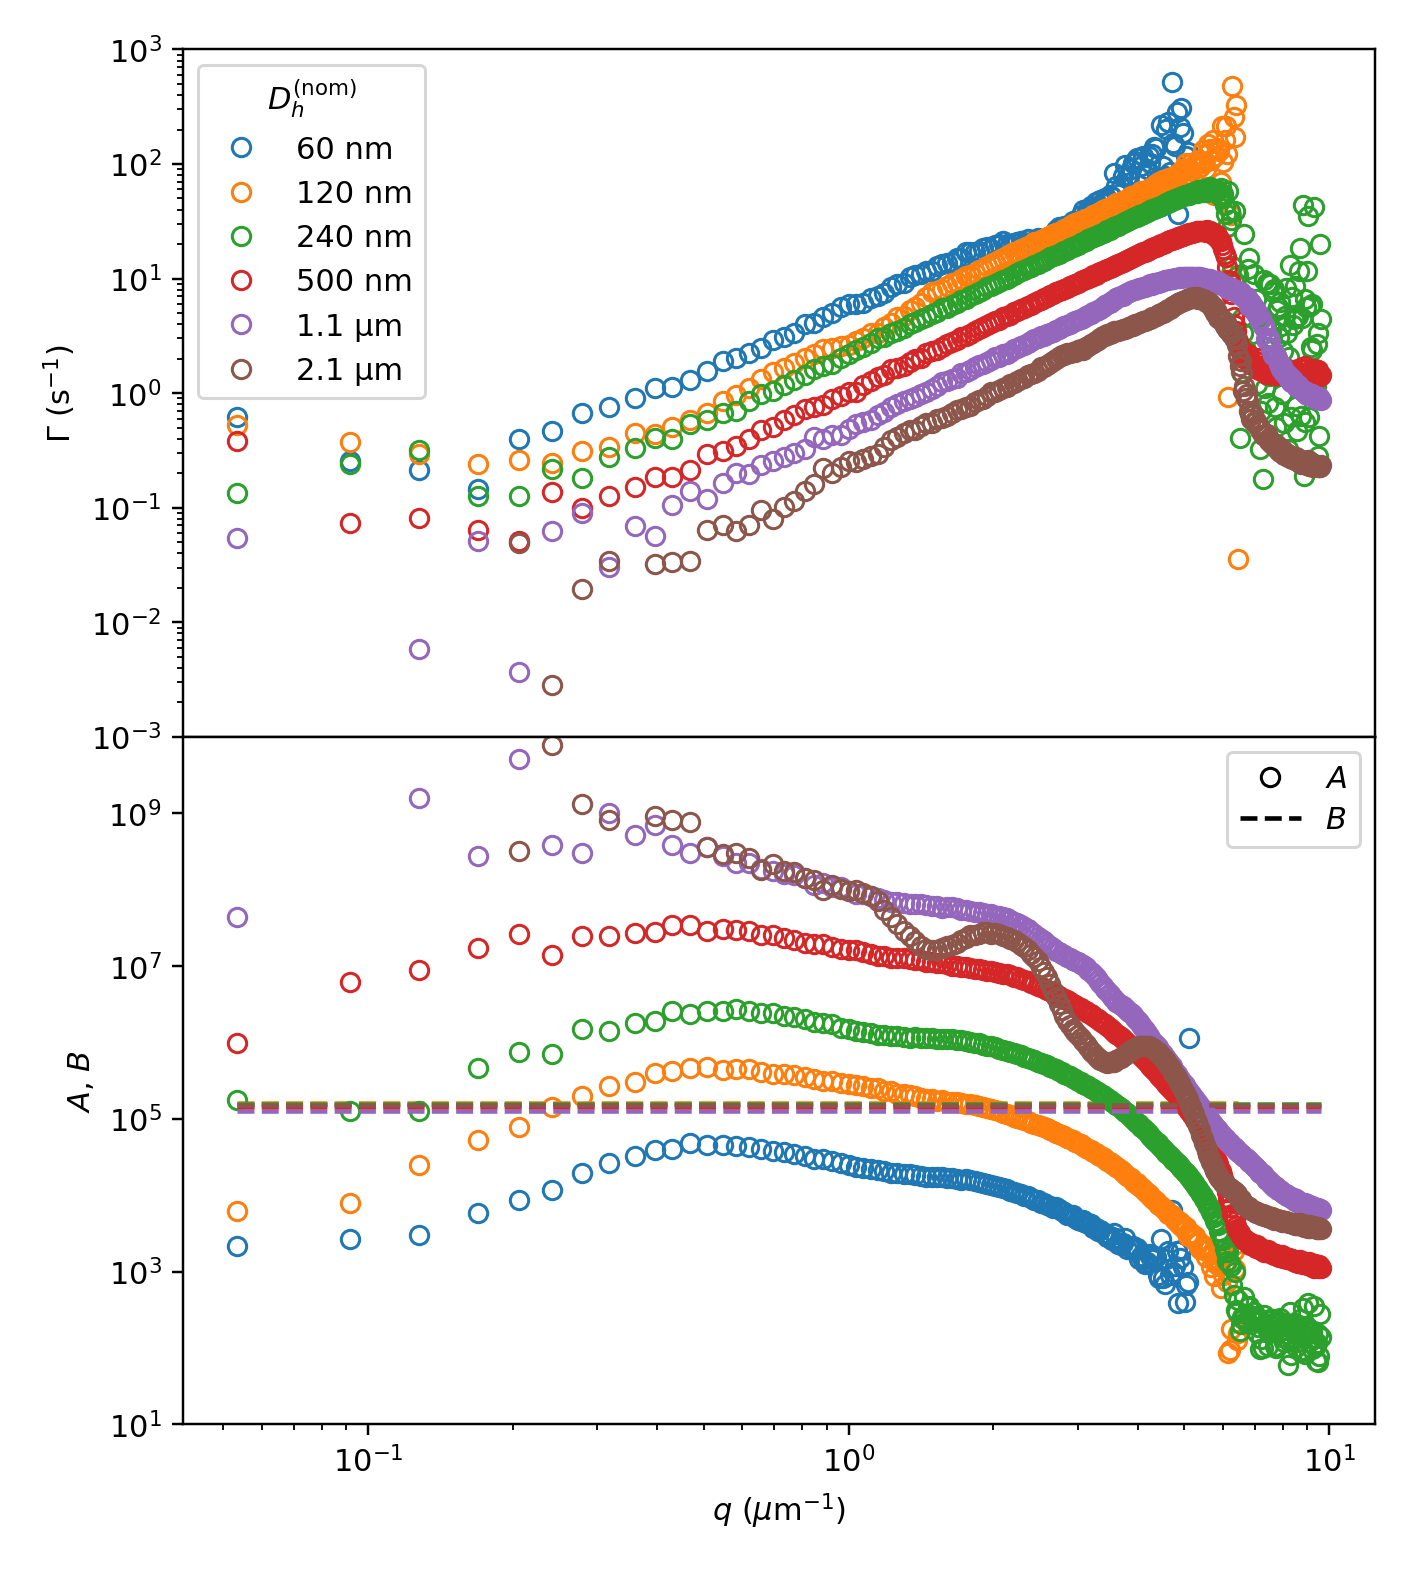

In [12]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

for n, (fr, label) in enumerate(zip(fit_res, labels)):
    fr_filtered = fr[fr['success']].dropna()
    axs[0].plot(fr_filtered['k'], fr_filtered['Gamma'], f'C{n}o', markerfacecolor='none', label=label)
    axs[1].plot(fr_filtered['k'], fr_filtered['A'], f'C{n}o', markerfacecolor='none')
    axs[1].plot(fr_filtered['k'],
                np.full_like(fr_filtered['B'], fill_value=fr_filtered['B'].mean()),
                f'C{n}--')
    
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].set_ylim(1e-3, 1e3)
axs[0].legend(title=r'$D_h^{\mathrm{(nom)}}$')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
axs[1].set_ylim(1e1, 1e10)
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none', color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

fig.tight_layout();

Let's inspect first the plot at the bottom. The value of $B$ was averaged over the range of wave vectors for ease of representation. However, it is rather flat. The amplitude $A$ shows instead a characteristic non-monotonic dependence on $q$: from low- to high-$q$, it increases, reaching a maximum (or a region where its value is larger), and then continuously decreases, eventually falling below the noise level.

Looking at the upper plot, the data for $\Gamma$ show a very nice power law behavior at intermediate $q$ values and become noisy at low and large wave vectors. In the high-$q$ region, they also display an abrupt drop.

Why is this happening? It is time, now, to discuss the limitations of the technique.

### 2.C. Limits of Differential Dynamic Microscopy

The limitations of Differential Dynamic Microscopy stem from the limitation of image collection and ultimately on the limits of microscopy itself.

The range of $\Gamma$ is directly limited from the top by the speed at which images are collected. Clearly, we cannot measure a dynamics which is faster than the image acquisition speed. We can then define an upper limit of $\Gamma$ as

$$
\gamma_0 = 1 / \Delta t_{\mathrm{min}} (= \text{frame rate}) .
$$

Following the same reasoning, we cannot measure a dynamics slower than the total acquisition time $\Delta t_{\mathrm{meas}}$. The lower limit of $\Gamma$ can then be defined as

$$
\gamma_T = 1 / \Delta t_{\mathrm{max}} .
$$
In this case, $\Delta t_{\mathrm{max}}$ can also indicate the maximum delay analyzed with DDM (of course, $\Delta t_{\mathrm{max}} < \Delta t_{\mathrm{meas}}$).


For what concerns the wave vector limitations, there are multiple effects involved. The most direct one is connected to the frequencies produced by the Fourier transform. The minimum wave vector associated with the FFT (excluded 0 which is connected to the average intensity of the image) is

$$
q_{\mathrm{min}} = \frac{2 \pi}{L_{\mathrm{max}}} ,
$$
where $L_{\mathrm{max}}$ is the (effective) largest image spatial dimension over x and y.

For the same reason, the upper limit is

$$
q_{\mathrm{px}} = \frac{\pi}{\delta_{\mathrm{px}}} ,
$$
where $\delta_{\mathrm{px}}$ is the (effective) pixel size.

For what concerns the upper limit, the actual limitation usually comes from the maximum angle accepted by the collection optics. Specifically, the illumination wavelength $\lambda$ and the numerical aperture of the objective $\mathrm{NA}_o$ produce an upper limit for $q$ that reads (in the case of bright-field microscopy)

$$
q_{\mathrm{max}} = \frac{2 \pi \mathrm{NA}_o}{\lambda} .
$$

Typically, even for white light illumination, one can use a reference wavelength of 580 nm. Let's see what happens if we apply this limits to filter our data.

In [13]:
# optical parameters
L = pixel_size * 512
NAo = 0.5
lambda0 = 0.58

# limits
q_min = 2 * np.pi / L
q_max = 2 * np.pi * NAo / lambda0
gamma_T = 1 / aa[0].tau[-1]
gamma_0 = 1 / aa[0].tau[0]    # also, gamma_0 = frame_rate

# filter fit results
fit_res_filtered = []

for fr in fit_res:
    # remove non-succesful fits and nans
    tmp_df = fr[fr['success']].dropna()
    
    # filter q range
    tmp_df = tmp_df[(tmp_df['k'] >= q_min) & (tmp_df['k'] <= q_max)]
    
    # filter Gamma range
    tmp_df = tmp_df[(tmp_df['Gamma'] >= gamma_T) & (tmp_df['Gamma'] <= gamma_0)]
    
    # append to list
    fit_res_filtered.append(tmp_df) 

<IPython.core.display.Javascript object>


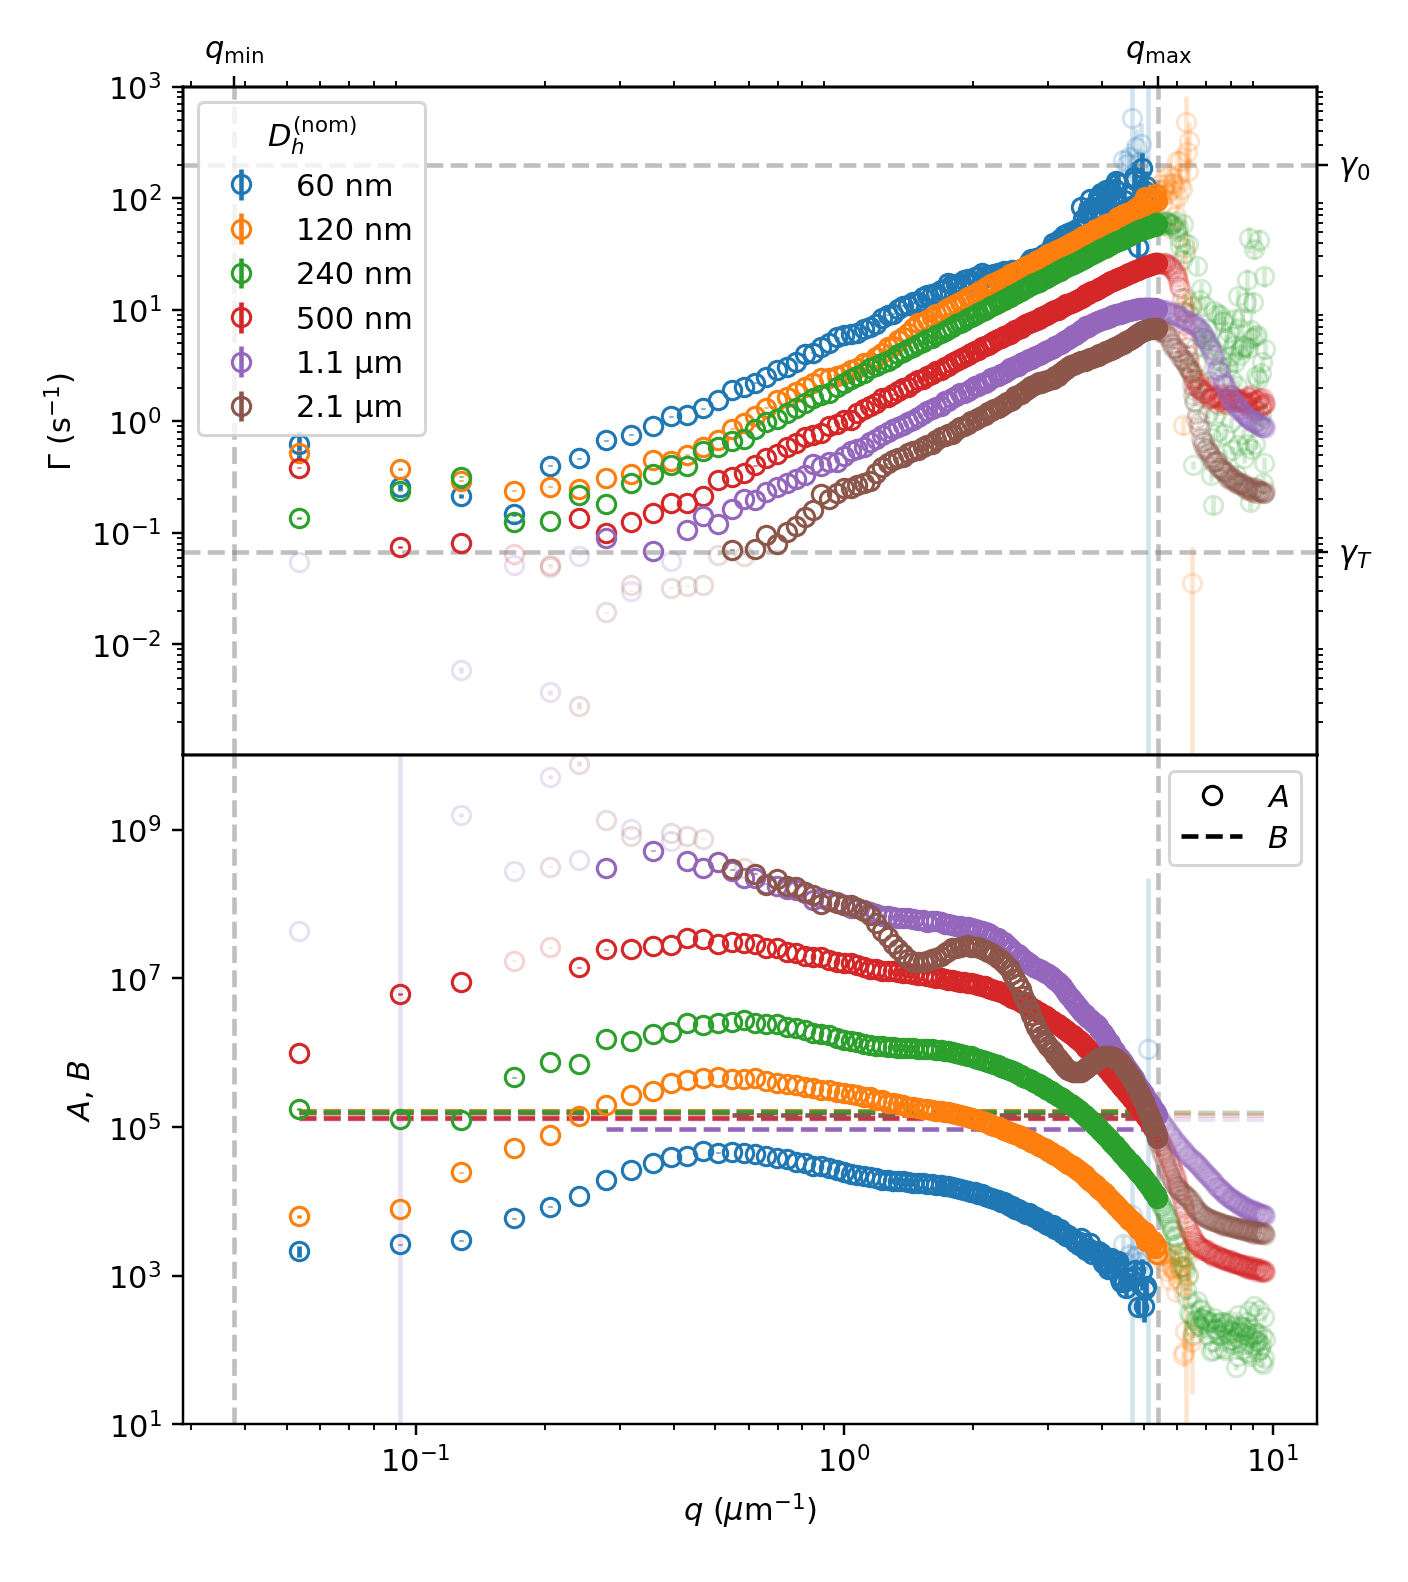

In [14]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, frf, label) in enumerate(zip(fit_res, fit_res_filtered, labels)):
    # filter only nan and non-successful fits
    tmp_df = fr[fr['success']].dropna()
    
    # display the full data (with transparency)
    axs[0].errorbar(
        tmp_df['k'],
        tmp_df['Gamma'],
        yerr=tmp_df['Gamma_stderr'],
        fmt=f'C{n}o', alpha=0.2,
        markerfacecolor='none',
    )
    axs[1].errorbar(
        tmp_df['k'],
        tmp_df['A'],
        yerr=tmp_df['A_stderr'],
        fmt=f'C{n}o', alpha=0.2,
        markerfacecolor='none',
    )
    axs[1].plot(
        tmp_df['k'],
        np.full_like(tmp_df['B'], fill_value=tmp_df['B'].mean()),
        f'C{n}--', alpha=0.2
    )
    
    # display the filtered data
    axs[0].errorbar(
        frf['k'],
        frf['Gamma'],
        yerr=frf['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        frf['k'],
        frf['A'],
        yerr=frf['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none'
    )
    axs[1].plot(
        frf['k'],
        np.full_like(frf['B'], fill_value=frf['B'].mean()),
        f'C{n}--'
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].set_ylim(1.01e-3, 1e3)
axs[0].legend(title=r'$D_h^{\mathrm{(nom)}}$')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
axs[1].set_ylim(1e1, 1e10)
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none', color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')    

# plot Gamma limits
axs[0].axhline(gamma_T, color='gray', linestyle='--', alpha=0.5)
axs[0].axhline(gamma_0, color='gray', linestyle='--', alpha=0.5)

axtwin = axs[0].twinx()
axtwin.set_yscale('log')
axtwin.set_ylim(1.01e-3, 1e3)
yticks = [gamma_T, gamma_0]
yticklabels = [r'$\gamma_T$', r'$\gamma_0$']
axtwin.set_yticks(yticks)
axtwin.set_yticklabels(yticklabels)

# plot q limits
axs[0].axvline(x=q_min, color='gray', linestyle='--', alpha=0.5)
axs[0].axvline(x=q_max, color='gray', linestyle='--', alpha=0.5)
axs[1].axvline(x=q_min, color='gray', linestyle='--', alpha=0.5)
axs[1].axvline(x=q_max, color='gray', linestyle='--', alpha=0.5)

axtwinx = axs[0].twiny()
axtwinx.set_xscale('log')
xticks = [q_min, q_max]
xticklabels = [r'$q_{\mathrm{min}}$', r'$q_{\mathrm{max}}$']
axtwinx.set_xticks(xticks)
axtwinx.set_xticklabels(xticklabels)
axtwinx.set_xlim(axs[1].get_xlim())

fig.tight_layout();

This first filtering is sufficient to discard most of the points outside the measurable range.

### 2.D. Fit $\Gamma$ to retrieve the diffusion coefficient

For *purely diffusive dynamics*, the relaxation rate and diffusion coefficient $D$ are connected via

$$
\Gamma = D q^2 .
$$
By fitting $\Gamma$ using this power law model, we can extract the diffusion coefficient.

At low wave vectors, the relaxation rate cannot be reliably measured and produces points that are virtually still in the measurement interval. We can start with a tentative fit, using the data we have after the filtering, and then discard the points for which the fit line highlights the spurious dynamics (i.e., where the wave vectors for which the fit line falls below the $\gamma_T$ limit).

In [15]:
# fit Gamma using Dq^2 model
# we actually fit the logarithm of Gamma, so we define log(Dq^2)
# define model
def log_Dq2(x, D):
    return np.log(D * x**2)
model_Gamma = lmfit.Model(log_Dq2, nan_policy="omit")
model_Gamma.set_param_hint("D", min=0.0, value=1.0)

# fit Gamma
D = []
D_err = []
for fr in fit_res_filtered:
    Gamma_fit_res = fit(model_Gamma,
                        xdata=fr['k'],
                        ydata=np.log(fr['Gamma']),
                        weights=fr['Gamma']/fr['Gamma_stderr'])
    D.append(Gamma_fit_res.params["D"].value)
    D_err.append(Gamma_fit_res.params["D"].stderr)

<IPython.core.display.Javascript object>


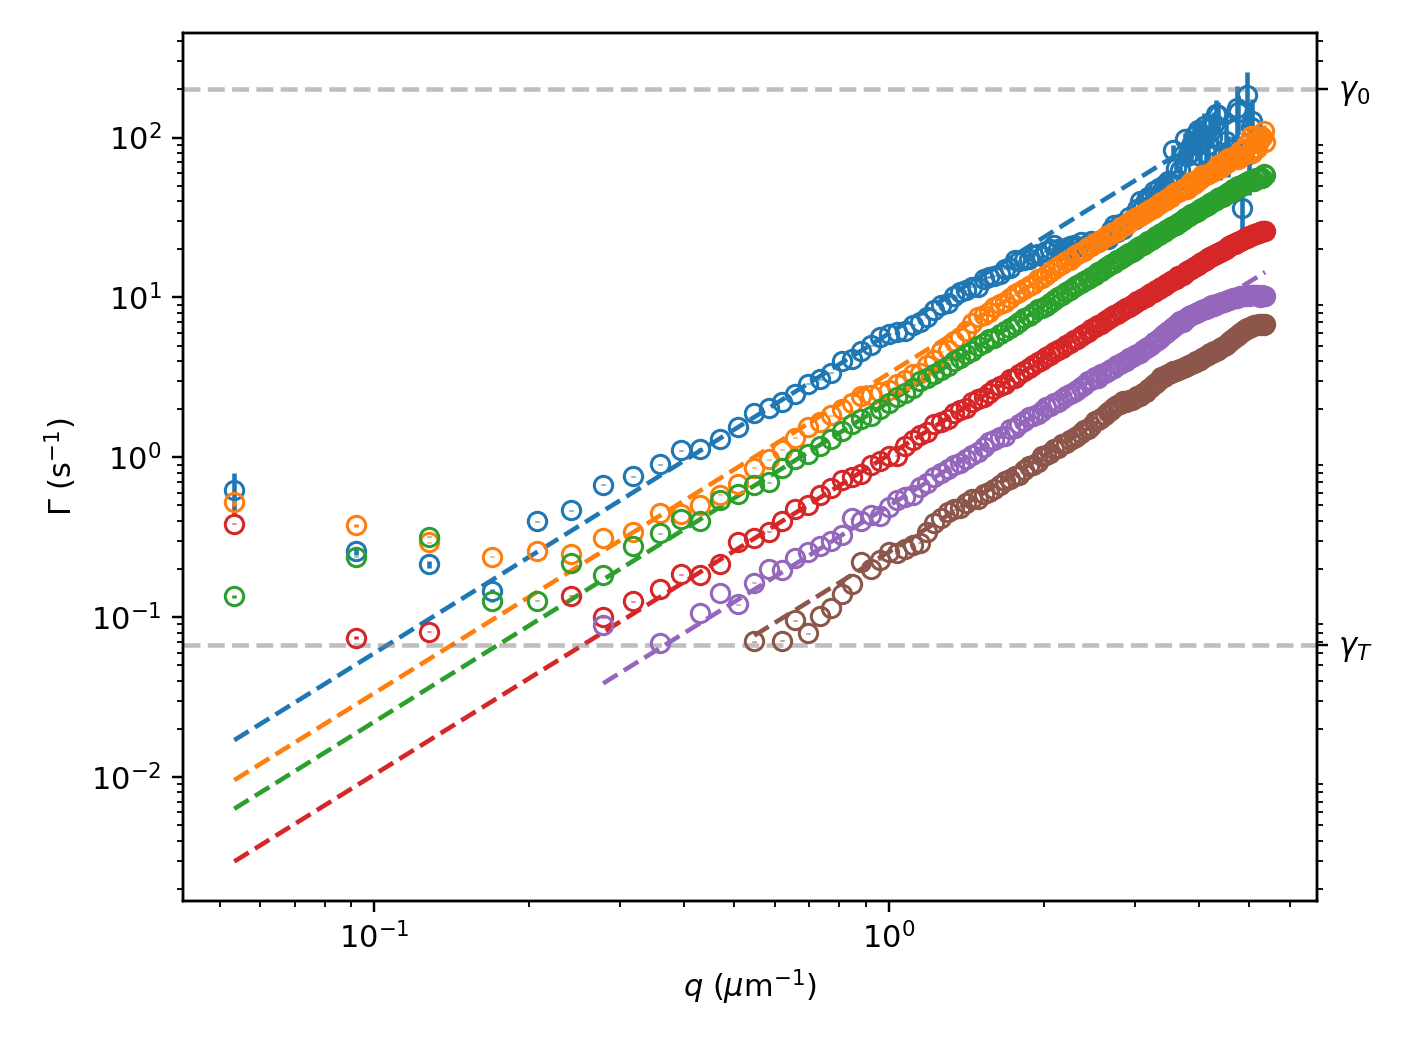

In [16]:
# plot again Gamma with the fit lines
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for n, (frf, label) in enumerate(zip(fit_res_filtered, labels)):
    ax.errorbar(
        frf['k'],
        frf['Gamma'],
        yerr=frf['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    ax.plot(
        frf['k'],
        D[n] * frf['k']**2,
        f'C{n}--'
    )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
    
# plot Gamma limits
ax.axhline(gamma_T, color='gray', linestyle='--', alpha=0.5)
ax.axhline(gamma_0, color='gray', linestyle='--', alpha=0.5)

axtwin = ax.twinx()
axtwin.set_yscale('log')
axtwin.set_ylim(ax.get_ylim())
yticks = [gamma_T, gamma_0]
yticklabels = [r'$\gamma_T$', r'$\gamma_0$']
axtwin.set_yticks(yticks)
axtwin.set_yticklabels(yticklabels)

fig.tight_layout();

For some of the samples, the fit line falls below $\gamma_T$ after the first data points. We can use it to further filter the data. Since the number of spurious points is small, we can expect the effect on the results to be small as well.

In [17]:
# filter again the results to exclude meaningless points after Dq^2 has crossed the gamma_T line
fit_res_filtered2 = []

for frf, d in zip(fit_res_filtered, D):
    fit_res_filtered2.append(frf[d * frf['k']**2 > gamma_T])

We fit the new filtered data and we show once more the filtered out data points in transparency.

In [18]:
# fit Gamma
D2 = []
D_err2 = []
for fr in fit_res_filtered2:
    Gamma_fit_res = fit(model_Gamma,
                        xdata=fr['k'],
                        ydata=np.log(fr['Gamma']),
                        weights=fr['Gamma']/fr['Gamma_stderr'])
    D2.append(Gamma_fit_res.params["D"].value)
    D_err2.append(Gamma_fit_res.params["D"].stderr)

<IPython.core.display.Javascript object>


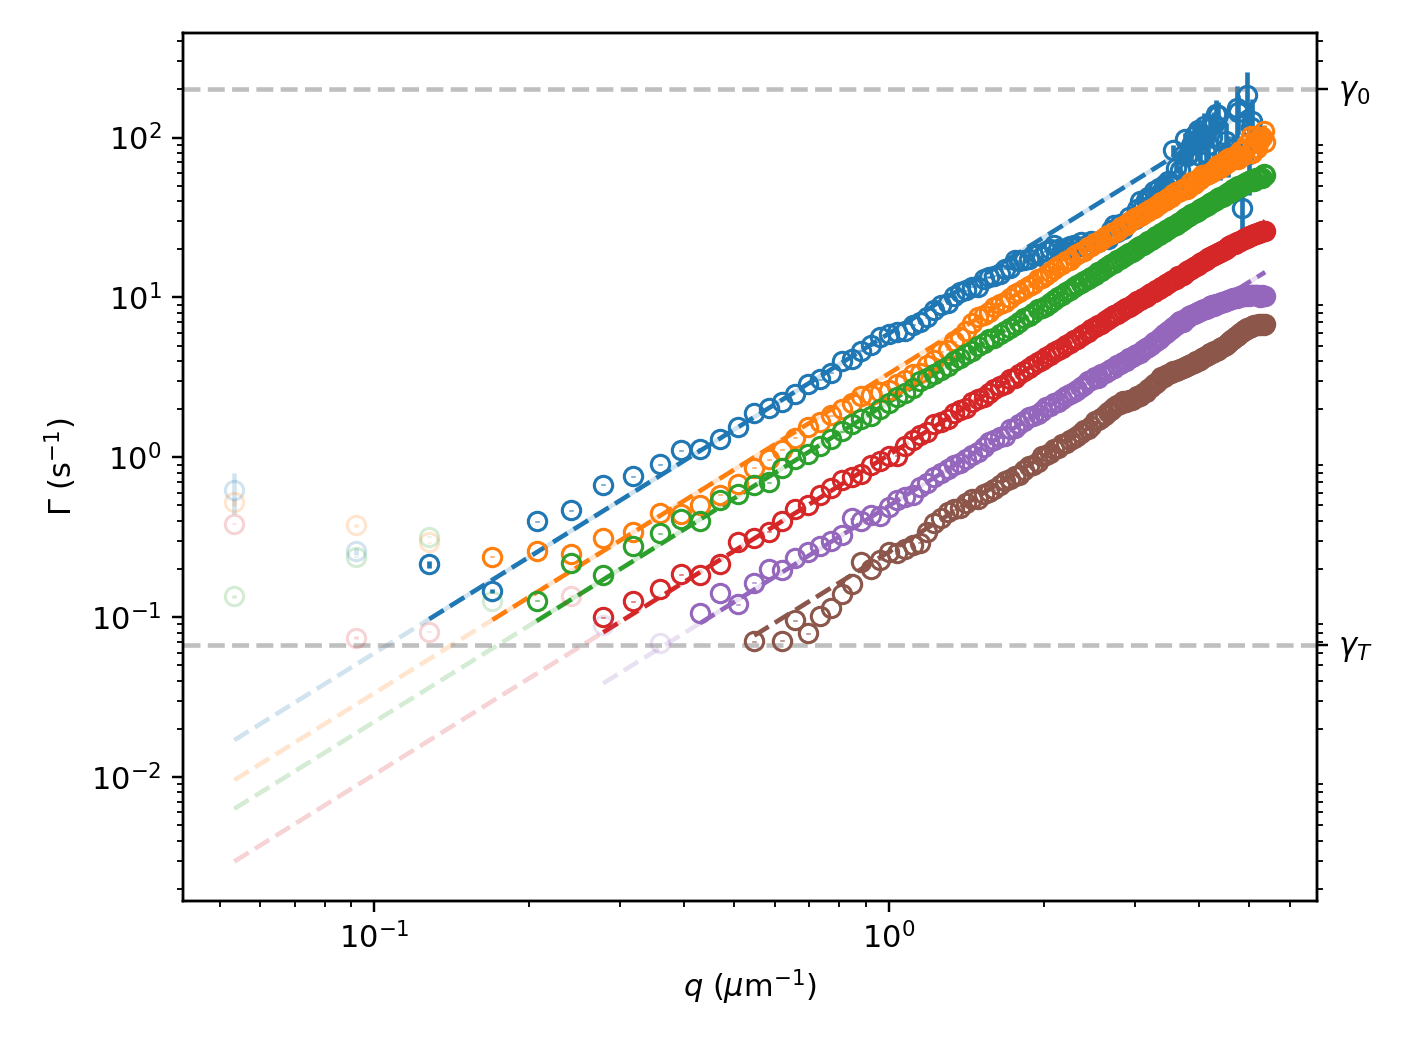

In [19]:
# plot again Gamma with the fit lines
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for n, (frf, frf2, label) in enumerate(zip(fit_res_filtered, fit_res_filtered2, labels)):
    # previous filtered data in transparency
    ax.errorbar(
        frf['k'],
        frf['Gamma'],
        yerr=frf['Gamma_stderr'],
        fmt=f'C{n}o', alpha=0.2,
        markerfacecolor='none',
        label=label,
    )
    ax.plot(
        frf['k'],
        D[n] * frf['k']**2,
        f'C{n}--', alpha=0.2,
    )
    
    # new filtered data
    ax.errorbar(
        frf2['k'],
        frf2['Gamma'],
        yerr=frf2['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label,
    )
    ax.plot(
        frf2['k'],
        D2[n] * frf2['k']**2,
        f'C{n}--',
    )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$\Gamma$ (s$^{-1}$)')
    
# plot Gamma limits
ax.axhline(gamma_T, color='gray', linestyle='--', alpha=0.5)
ax.axhline(gamma_0, color='gray', linestyle='--', alpha=0.5)

axtwin = ax.twinx()
axtwin.set_yscale('log')
axtwin.set_ylim(ax.get_ylim())
yticks = [gamma_T, gamma_0]
yticklabels = [r'$\gamma_T$', r'$\gamma_0$']
axtwin.set_yticks(yticks)
axtwin.set_yticklabels(yticklabels)

fig.tight_layout();

In [20]:
print(f'D_nom (nm) \t D (µm²/s) \t D (µm²/s) [refined]')
print('-'*52)
for dnom, d, derr, d2, derr2 in zip(D_nom, D, D_err, D2, D_err2):
    print(f'{dnom:<10} \t {d:.3f} ± {derr:.3f} \t {d2:.3f} ± {derr2:.3f}')

D_nom (nm) 	 D (µm²/s) 	 D (µm²/s) [refined]
----------------------------------------------------
60         	 5.960 ± 0.082 	 5.958 ± 0.082
120        	 3.351 ± 0.031 	 3.346 ± 0.027
240        	 2.217 ± 0.011 	 2.215 ± 0.006
500        	 1.038 ± 0.005 	 1.037 ± 0.002
1100       	 0.497 ± 0.002 	 0.497 ± 0.002
2100       	 0.256 ± 0.001 	 0.256 ± 0.001


As expected, since we removed only a few data points, tthe change in the fitted diffusion coefficient is negligible.

## 3. From diffusion coefficient to particle size

To obtain particle sizes, we make use of the Stokes-Einstein relation, which connects the diffusion coefficients $D$ we obtained from the previous step to the particle hydrodynamic radius $R_h$. The equation reads

$$
D = \frac{k_B T}{6 \pi \eta R_h} ,
$$
where $k_B = 1.38\times 10^{-23} \, \mathrm{J/K}$ is the Boltzmann constant, $T$ is the absolute temperature, and $\eta$ is the solvent viscosity.

We can safely assume that the measurements were performed at 25 °C. Since we know the solvent is water, we can use the value of its viscosity at this temperature ($\eta = 8.9 \times 10^{-4} \, \mathrm{Pa \cdot s}$).

In [21]:
# define experimental conditions
T = 25        # temperature (Celsius)
T += 273.15   # convert temperature to kelvin

kB = 1.38e-23 # Boltzmann constant (J / K)

kT = kB * T   # thermal energy (J)

eta = 8.9e-4  # viscosity (Pa s)

In [22]:
# define conversion from D to Rh
def diffcoeff_2_radius(D, kT, eta):
    return kT / (6 * np.pi * eta * D)

# calculate hydrodynamic radii
Rh = []
Rh_err = []
for d, de in zip(D2, D_err2):
    # convert diffusion coefficient from um2/s to m2/s
    dd = d * 1e-12
    
    # calculate radius
    Rh.append(diffcoeff_2_radius(dd, kT, eta))
    Rh_err.append(Rh[-1] * de / d)

# convert hydrodynamic radius from m to nm
Rh = np.array(Rh) * 1e9
Rh_err = np.array(Rh_err) * 1e9

We can now compare the nominal and measured values of the hydrodynamic size. Since we have the nominal diameters, we just multiply the measured values by 2.

<IPython.core.display.Javascript object>


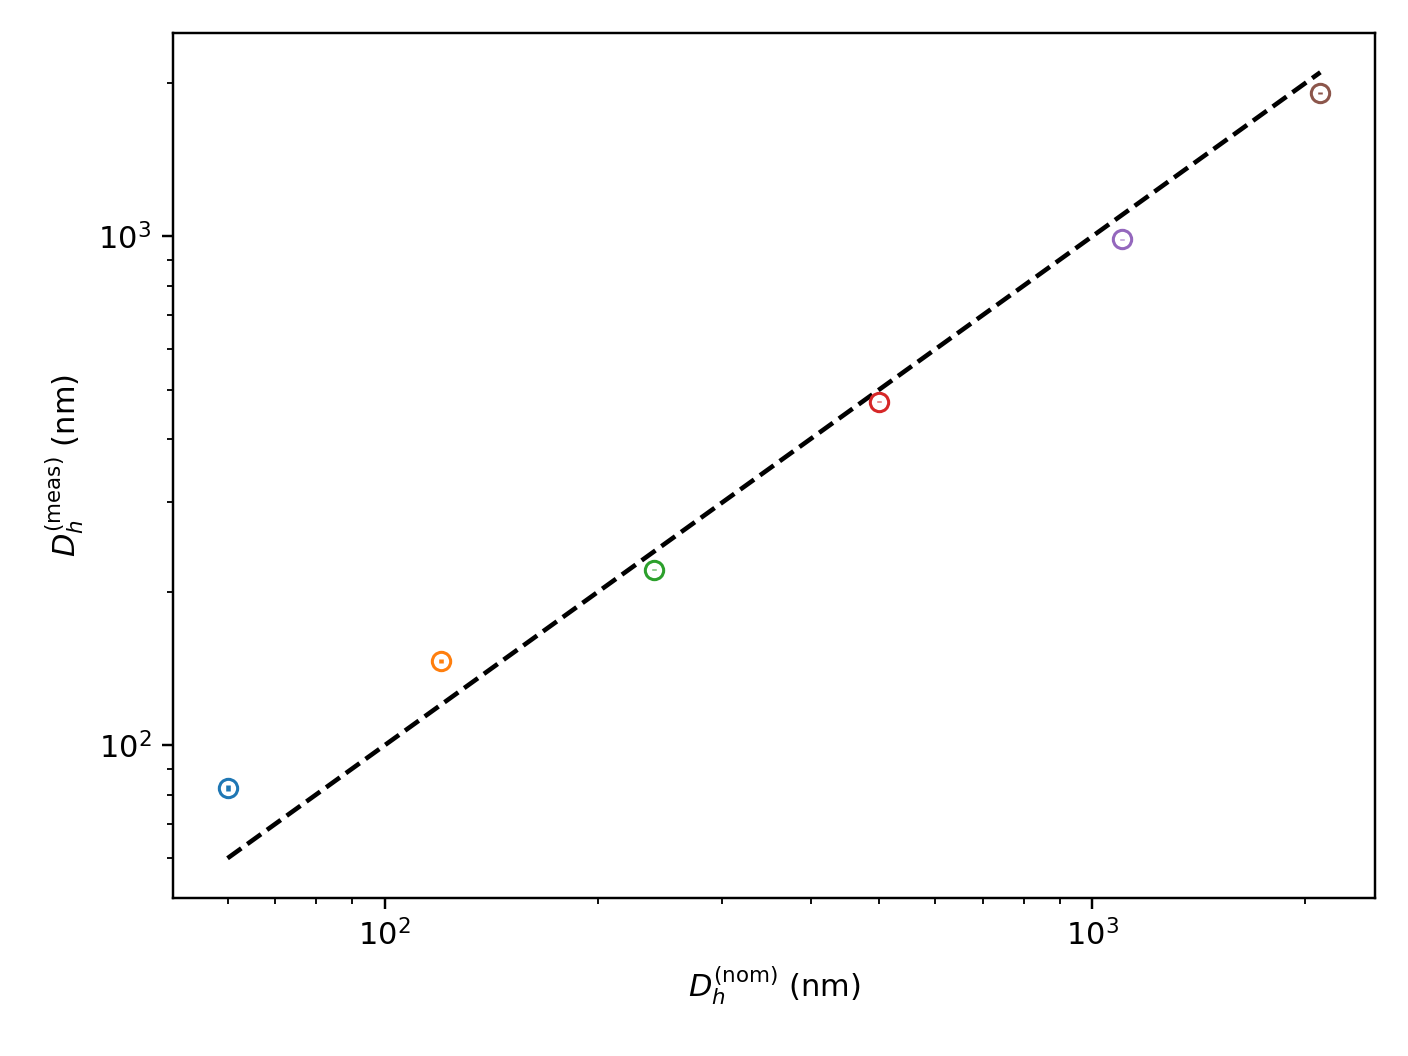

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# plot measured hydrodynamic radii
for n, (d, r, rerr) in enumerate(zip(D_nom, Rh, Rh_err)):
    ax.errorbar(d, 2 * r, yerr=2*rerr, markerfacecolor='none', fmt=f'C{n}o')
    
# plot reference line
ax.plot(D_nom, D_nom, 'k--')

ax.set_xscale('log')
ax.set_xlabel(r'$D_h^{\mathrm{(nom)}}$ (nm)')
ax.set_yscale('log')
ax.set_ylabel(r'$D_h^{\mathrm{(meas)}}$ (nm)')

fig.tight_layout();

We also print a table of the measured diffusion coefficients and hydrodynamic diameters with their corresponding error.

In [24]:
print(f'D_nom (nm) \t D (µm²/s) \t Dh (nm)')
print('-'*45)

for dnom, d, derr, r, rerr in zip(D_nom, D2, D_err2, Rh, Rh_err):
    print(f'{dnom:<10} \t {d:.3f} ± {derr:.3f} \t {2*r:6.1f} ± {2*rerr:.1f}')

print('-'*45)

D_nom (nm) 	 D (µm²/s) 	 Dh (nm)
---------------------------------------------
60         	 5.958 ± 0.082 	   82.3 ± 1.1
120        	 3.346 ± 0.027 	  146.6 ± 1.2
240        	 2.215 ± 0.006 	  221.5 ± 0.6
500        	 1.037 ± 0.002 	  473.0 ± 0.9
1100       	 0.497 ± 0.002 	  986.6 ± 3.2
2100       	 0.256 ± 0.001 	 1914.0 ± 8.7
---------------------------------------------


# (\*) Figures for paper

This last section is not part of the tutorial. If you are interested in getting the images used for the particle sizing section of our publication, feel free to set the following flag to `True` and run the cells below. You will need the `scienceplots` package, which is not among the ones required for these tutorials. You can install it through `pip`.

In [25]:
save_figures = False

In [26]:
if save_figures:
    # --- imports ---
    import scienceplots

    plt.style.use(['science', 'nature', 'vibrant'])
    mpl.rcParams['lines.markeredgewidth'] = 0.7
    
    # create FIGS directory
    os.makedirs('FIGS', exist_ok=True)

In [27]:
if save_figures:
    # --- save comparison f(q,dt) / fit ---
    fig = plt.figure()
    fig.set_figheight((len(aa) / 2) * fig.get_figheight())
    gs = fig.add_gridspec(len(aa), hspace=0)
    axs = gs.subplots(sharex=True)

    # select range of wave vector indices
    k_min = [10, 10, 10, 15, 20, 30]
    k_max = [50, 80, 80, 80, 90, 100]
    k_step = [7, 10, 10, 10, 10, 10]

    k_range = [range(k_m, k_M, k_s) for k_m, k_M, k_s in zip(k_min, k_max, k_step)]

    # plot curves
    for ax, a, ar, fr, mr, kr, l in zip(axs, aa, aa_resampled, fit_res, model_res, k_range, labels):
        cspace = color_space(len(kr))

        for k_idx, c in zip(kr, cspace):
            # calculate intermediate scattering function
            fqt = 1 - (ar.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
            fqt_fit = 1 - (mr[k_idx].best_fit - fr['B'][k_idx]) / fr['A'][k_idx]
    
            # plot
            ax.plot(ar.tau, fqt, '.', color=c)
            ax.plot(a.tau, fqt_fit, '-', color=c)
        
            # misc
            ax.set_ylabel(r'$f(\Delta t; q)$')
            ax.set_ylim(-0.1, 1.1)
            # label
            at = AnchoredText(l, prop=dict(size=10), frameon=True, loc='upper right')
            ax.add_artist(at)
            # custom legend
            custom_lines = [
                Line2D([0], [0], marker='.', linestyle='none', color='black', label='data'),
                Line2D([0], [0], linestyle='-', color='black', label='fit'),
            ]
            ax.legend(handles=custom_lines, labelspacing=0.4, loc='lower left')
        
    axs[-1].set_xscale('log')
    axs[-1].set_xlabel(r'$\Delta t$ (s)')

    fig.tight_layout()
    
    fig.savefig('FIGS/fqt.pdf', dpi=600);

In [28]:
if save_figures:
    # --- save fit parameters ---
    fig = plt.figure()
    fig.set_figheight(1.7 * fig.get_figheight())
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True)

    # plot
    for n, (fr, frf, d, label) in enumerate(zip(fit_res, fit_res_filtered2, D2, labels)):
        # filter only nan and non-successful fits
        tmp_df = fr[fr['success']].dropna()
    
        # display the full data (with transparency)
        axs[0].errorbar(
            tmp_df['k'],
            tmp_df['Gamma'],
            yerr=tmp_df['Gamma_stderr'],
            fmt=f'C{n}o', alpha=0.2,
            markerfacecolor='none',
        )
        axs[1].errorbar(
            tmp_df['k'],
            tmp_df['A'],
            yerr=tmp_df['A_stderr'],
            fmt=f'C{n}o', alpha=0.2,
            markerfacecolor='none',
        )
        axs[1].plot(
            tmp_df['k'],
            np.full_like(tmp_df['B'], fill_value=tmp_df['B'].mean()),
            f'C{n}--', alpha=0.2
        )
    
        # display the filtered data
        axs[0].errorbar(
            frf['k'],
            frf['Gamma'],
            yerr=frf['Gamma_stderr'],
            fmt=f'C{n}o',
            markerfacecolor='none',
            label=label
        )
        axs[1].errorbar(
            frf['k'],
            frf['A'],
            yerr=frf['A_stderr'],
            fmt=f'C{n}o',
            markerfacecolor='none'
        )
        axs[1].plot(
            frf['k'],
            np.full_like(frf['B'], fill_value=frf['B'].mean()),
            f'C{n}--'
        )
        
        # display the Gamma fit
        axs[0].plot(
            tmp_df['k'],
            d * tmp_df['k']**2,
            f'C{n}--'
        )

    # settings
    axs[0].set_yscale('log')
    axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
    axs[0].set_ylim(1.01e-2, 1e3)
    axs[0].legend(title=r'$D_h^{\mathrm{(nom)}}$')
    axs[1].set_xscale('log')
    axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
    axs[1].set_yscale('log')
    axs[1].set_ylabel(r'$A$, $B$')
    axs[1].set_ylim(1e1, 1e10)
    custom_lines = [
        Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none', color='black', label=r'$A$'),
        Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
    ]
    axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='lower center')
    
    at = [
        AnchoredText("a)", prop=dict(size=10), frameon=False, loc='lower right'),
        AnchoredText("b)", prop=dict(size=10), frameon=False, loc='upper right'),
    ]
    for _a, _at in zip(axs, at):
        _a.add_artist(_at)

    # plot Gamma limits
    axs[0].axhline(gamma_T, color='gray', linestyle='--', alpha=0.8)
    axs[0].axhline(gamma_0, color='gray', linestyle='--', alpha=0.8)

    axtwin = axs[0].twinx()
    axtwin.set_yscale('log')
    axtwin.set_ylim(axs[0].get_ylim())
    yticks = [gamma_T, gamma_0]
    yticklabels = [r'$\gamma_T$', r'$\gamma_0$']
    axtwin.set_yticks(yticks)
    axtwin.set_yticklabels(yticklabels)

    # plot q limits
    axs[0].axvline(x=q_min, color='gray', linestyle='--', alpha=0.8)
    axs[0].axvline(x=q_max, color='gray', linestyle='--', alpha=0.8)
    axs[1].axvline(x=q_min, color='gray', linestyle='--', alpha=0.8)
    axs[1].axvline(x=q_max, color='gray', linestyle='--', alpha=0.8)

    axtwinx = axs[0].twiny()
    axtwinx.set_xscale('log')
    xticks = [q_min, q_max]
    xticklabels = [r'$q_{\mathrm{min}}$', r'$q_{\mathrm{max}}$']
    axtwinx.set_xticks(xticks)
    axtwinx.set_xticklabels(xticklabels)
    axtwinx.set_xlim(axs[1].get_xlim())

    fig.tight_layout()
    
    fig.savefig('FIGS/Gamma_AB.pdf', dpi=600);

In [29]:
if save_figures:
    # --- save hyrodynamic diameters ---
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    # list nominal diameters
    D_nom = [60, 120, 240, 500, 1100, 2100]
    
    # plot reference line
    ax.plot(D_nom, D_nom, 'k--')

    # plot measured hydrodynamic radii
    for n, (d, r, rerr) in enumerate(zip(D_nom, Rh, Rh_err)):
        ax.plot(d, 2 * r, f'C{n}o', markersize=6)

    ax.set_xscale('log')
    ax.set_xlabel(r'$D_h^{\mathrm{(nom)}}$ (nm)')
    ax.set_yscale('log')
    ax.set_ylabel(r'$D_h^{\mathrm{(meas)}}$ (nm)')

    fig.tight_layout()
    
    fig.savefig('FIGS/D_hydro.pdf', dpi=600);